# Learning-Based Model Predictive Control for Autonomous Racing

In this Notebook I am doing a quick implementation of the Learning-Based Model Predictive Control framework, proposed by Kabzan et.al. (2019). The paper that introduces this algorithm can be found through the following link.

https://www.research-collection.ethz.ch/handle/20.500.11850/351561

I am doing this implementation purely to understand the concept as detailed as possible in preperation for an interview for a master's thesis. If parts of the code (that are not part of any library) are not written by me, I will mark them as such. 

All credit for the development of this framework goes to Kabzan et.al..

All the constants, weights and gains are set to general or estimated values.

Notes: 
- Using functions is suboptimal (defining a class would propably be the better approach) but since this is supposed to just a quick implementation to get a better understanding, I did not bother.


In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

%matplotlib inline

First, I define the constants and initial values for the state vector and the driver input

In [170]:
# Gausian Process regression
w_value = 0.1 # zero-mean Gausian process noise value (with diagonal variance (diag([sigma_1^2, sigma_2^2, ..., sigma_nf^2])))

# Nominal Vehicle Model

m = 1000 # vehicle mass [kg]
I_z = 2000 # yaw moment of interia [kg m²]
l_R = 1.5 # distance from the center of gravity of the car to the rear axle [m]
l_F = 1.5 # distance from the center of gravity of the car to the front axle [m]
P_TV = 0.5 # proportional controller gain for the torque vectoring controler [positive real number]

D_F = 1 # Tire constants for the computation of the drive-train Y-forces
D_R = 1
C_F = 1.9
C_R = 1.9
B_F = 10
B_R = 10

C_m1 = 50 # Drivetrain constant for the Computation of F_x
C_r0 = 1 # Rolling resistance
C_r2 = 1 # Drag coefficient


### Initializing the first statevector for the model with the initial values----------------------------------------------

X_0 = 0 # Initial X position (global)
Y_0 = 0 # Initial Y position (global)
phi_0 = 0 # Initial heading angle (global)
v_x_0 = 0.000000001 # Initial x velocity (vehicle) not 0 to avoid problems with the integral
v_y_0 = 0.000000001 # Initial y velocity (vehicle) not 0 to avoid problems with the integral
r_0 = 0 # Initial yaw rate
delta_0 = 0 # Initial steering angle 
T_0 = 1 # Initial desired accaleration

x = np.array([[X_0, Y_0, phi_0, v_x_0, v_y_0, r_0, delta_0, T_0]]) # Initial state vector x


### Here I am initializing the first inputvector for the model with initial values----------------------------------------

d_delta_0 = 0 # Initial change in steering angle
d_T_0 = 0 # Initial change in desired acceleration

u = np.array([[d_delta_0, d_T_0]]) # Initial driver inputs to the system


In the next cell, all the relevant functions for the nominal state computation of the vehicle are defined

- Nominal vehicle state update is not implimented properly, however I did not figure out how to make the integration work with the function having basicaly 10 input variables and only 8 output variables due to the fact that delta_d and delta_T both appear in the state vector derivative. This is why the nominal vehicle state update only takes a statevector as input and always uses the last recorded driver input.

In [171]:
### Definition of the vehicle dynamics function---------------------------------------------------------------------------

# This function takes in a statevector x and outputs the analytical derivitive of the statevector x_dot.
# Uses the last element of the driver input vector u !!! 

def vehicle_dynamics(t, x):
    
    # Decomposing the statevector into its different values
    
    X = x[0]
    Y = x[1]
    phi = x[2]
    v_x = x[3]
    v_y = x[4]
    r = x[5]
    delta = x[6]
    T = x[7]
    d_delta = u[-1][0]
    d_T = u[-1][1]
    
    # Computing the additional yaw torque from the torque-controller, the front and read slip angles 
    # and the longitudinal drive-train forces.
    # l_R, l_F and P_TV are the distances to the front and read axles and the the gain for the 
    # torque-controller respectively
    
    r_target = delta*(v_x/(l_R+l_F))
    tau_TV = (r_target - r)*P_TV # Additional torque generated by the torque vectoring controller
    
    alpha_R = np.arctan((v_y - l_R*r)/v_x) # Front slip angle
    alpha_F = np.arctan((v_y + l_F*r)/v_x) - delta # Rear slip angle
    F_Ry = D_R*np.sin(C_R*np.arctan(B_R*alpha_R)) # Rear lateral force
    F_Fy = D_F*np.sin(C_F*np.arctan(B_F*alpha_F)) # Front lateral force
    F_x = C_m1*T - C_r0 - C_r2*(v_x**2) # Applied longitudinal force
    
    # Computing the values of x_dot seperately for better visibility
    
    X_dot = v_x*np.cos(phi) - v_y*np.sin(phi)
    Y_dot = v_x*np.sin(phi) + v_y*np.cos(phi)
    phi_dot = r
    v_x_dot = (F_x - F_Fy*np.sin(delta) + m*v_y*r)/m
    v_y_dot = (F_Ry + F_Fy*np.cos(delta) - m*v_x*r)/m
    r_dot =  (F_Fy*l_F*np.cos(delta) - F_Ry*l_R + tau_TV)/I_z
    delta_dot = d_delta 
    T_dot = d_T
    
    x_dot = np.array([X_dot, Y_dot, phi_dot, v_x_dot, v_y_dot, r_dot, delta_dot, T_dot])
    
    return x_dot


### Definition of the integration step for the nominal vehicle state------------------------------------------------------

# Use the Runge-Kutta 4/5th order integration to solve for the new nominal state of the vehicle
# This is probably not entirely right. If I set the initial velocity to 0, the integral gets stuck.

def nominal_vehicle_state(x):
    return solve_ivp(vehicle_dynamics, t_span = (0, 0.05), y0 = x).y.T[-1]
    
    
### Definition of the statevector update function-------------------------------------------------------------------------

# The function takes as input the current state x_k, 
# the subspace definition matrix B_d, the input of the Gausian Process regression,
# the Gausian noise diagonal matrix containing the variances and it outputs
# the next state of the vehicle x_k+1.

def state_vector_update(x, B_d, z, w):
    
    x_new = nominal_vehicle_state(x) + B_d@(d(z) + w)
    
    return x_new

Below I verify my implementation of the nominal state computation by running tests with some constant steering (0.1rad) and accaleration (1) inputs.

IMPORTANT: The acctual values e.g. acceleration are not realistic because I estimated all the constants like drivetrain and the constants for the tire model. This means that an acceleration of 1 which equals to the maximum acceleration possible would not result in the the kind of velocity increase you would expect.

In [172]:
### Initializing the first statevector for the model with the initial values----------------------------------------------

X_0 = 0 # Initial X position (global)
Y_0 = 0 # Initial Y position (global)
phi_0 = 0 # Initial heading angle (global)
v_x_0 = 0.000000000000001 # Initial x velocity (vehicle) not 0 to avoid problems with the integral
v_y_0 = 0.000000000000001 # Initial y velocity (vehicle) not 0 to avoid problems with the integral
r_0 = 0 # Initial yaw rate
delta_0 = 0.01 # Initial steering angle 
T_0 = 1 # Initial desired accaleration

x = np.array([[X_0, Y_0, phi_0, v_x_0, v_y_0, r_0, delta_0, T_0]]) # Initial state vector x

### Here I am initializing the first inputvector for the model with initial values----------------------------------------

d_delta_0 = 0 # Initial change in steering angle
d_T_0 = 0 # Initial change in desired acceleration

u = np.array([[d_delta_0, d_T_0]]) # Initial driver inputs to the system

for k in range(2000):
    z = np.array([nominal_vehicle_state(x[k])])
    x = np.append(x, z, axis=0) # appending the new statevector


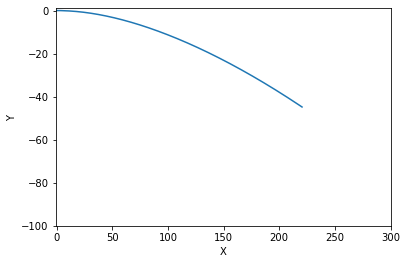

In [173]:
xplot = x.T[0]
yplot = x.T[1]
plt.xlim(-1,300)
plt.ylim(-100,1)
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(xplot,yplot)
plt.show()

The plot shows the X and Y coordinates of the vehicle after the first 2000 iterations (equal to 100 seconds). 
For a constant acceleration and steering angle the plot looks realistic.
The fact that with more iteration, the constant steering angle delta has less and less effect on the trajectory is possibly due to the decreasing sideslip angle, and the consequently decreasing lateral forces on the vehicle. 

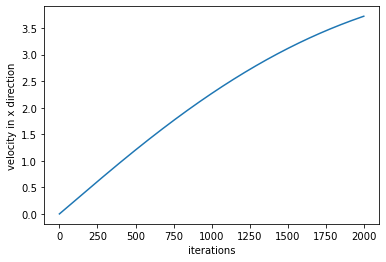

In [176]:
xplot = range(2001)
yplot = x.T[3]
plt.xlabel("iterations")
plt.ylabel("velocity in x direction")
plt.plot(xplot,yplot)
plt.show()

This plot also makes sense, since the velocity should increase linear with a constant accaleration. The flattening during the end is most likely due to the dragcoefficient preventing the vehicle from increasing its velocity linearly, and the fact that it steers towards negative Y over time, resulting in a decrease in velocity_x and an increase in velocity_y

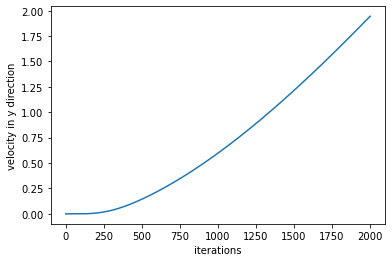

In [177]:
xplot = range(2001)
yplot = x.T[4]
plt.xlabel("iterations")
plt.ylabel("velocity in y direction")
plt.plot(xplot,yplot)
plt.show()

In [178]:
### Computing and appending the new statevector and the new driver input--------------------------------------------------

#x_new = state_vector_update(x[k], u[k], B_d, z[k], w[k]) # Computing x[k+1]

#Das ist nicht korrekt, beschreibt u[k] u_new muss anders gefunden werden
#u_new = vehicle_dynamics(x, u)[6:8] # Computing u[k+1]

#x = np.append(x, x_new, axis=0) # appending the new statevector
#u = np.append(u, u_new, axis=0) # appending the new driver input